# Combining daily Wikipedia PageViews and YouTube uploads

## imports

In [9]:
import pandas as pd

In [10]:
import matplotlib.pyplot as plt


## reading data from csv files

In [3]:
df_wiki = pd.read_csv("csv/quest2_wiki_daily.csv") 
df_wiki

,Unnamed: 0,Alternative_für_Deutschland
0,2024-11-01,1223
1,2024-11-02,1323
2,2024-11-03,1309
3,2024-11-04,1601
4,2024-11-05,1769
...,...,...
115,2025-02-24,46538
116,2025-02-25,19592
117,2025-02-26,14399
118,2025-02-27,8108


In [4]:
df_videos = pd.read_csv("csv/quest2_yt_daily.csv")
df_videos

,Published At,Number of Videos
0,2024-11-01 00:00:00+00:00,7
1,2024-11-02 00:00:00+00:00,3
2,2024-11-03 00:00:00+00:00,9
3,2024-11-04 00:00:00+00:00,4
4,2024-11-05 00:00:00+00:00,1
...,...,...
115,2025-02-24 00:00:00+00:00,24
116,2025-02-25 00:00:00+00:00,13
117,2025-02-26 00:00:00+00:00,9
118,2025-02-27 00:00:00+00:00,10


## merging both dataframes

In [5]:
# Rename columns for clarity
df_wiki = df_wiki.rename(columns={'Unnamed: 0': 'Published At', 'Alternative_für_Deutschland' : 'Wikipedia Pageviews'})

# Ensure both columns are datetime
df_videos['Published At'] = pd.to_datetime(df_videos['Published At'], errors='coerce')
df_wiki['Published At'] = pd.to_datetime(df_wiki['Published At'], errors='coerce')

# Remove timezone from df_videos if it exists
if df_videos['Published At'].dt.tz is not None:
    df_videos['Published At'] = df_videos['Published At'].dt.tz_localize(None)


# Merge on 'Published At'
df_merged = pd.merge(df_videos, df_wiki, on='Published At', how='inner')


df_merged

,Published At,Number of Videos,Wikipedia Pageviews
0,2024-11-01,7,1223
1,2024-11-02,3,1323
2,2024-11-03,9,1309
3,2024-11-04,4,1601
4,2024-11-05,1,1769
...,...,...,...
115,2025-02-24,24,46538
116,2025-02-25,13,19592
117,2025-02-26,9,14399
118,2025-02-27,10,8108


In [6]:
def normalize_to_relative(df, columns):
    """
    Convert the specified columns in a DataFrame to relative values
    (each value divided by the total of its column).

    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): List of column names to normalize

    Returns:
        pd.DataFrame: DataFrame with normalized columns
    """
    df_relative = df.copy()
    for col in columns:
        total = df_relative[col].sum()
        df_relative[col] = df_relative[col] / total*100
    return df_relative

# Example usage:
columns_to_normalize = ['Number of Videos', 'Wikipedia Pageviews']
df_relative = normalize_to_relative(df_merged, columns_to_normalize)

# Make 'Published At' the index

df_relative.to_csv('AfD_combined_daily_relative.csv')
df_relative2 = df_relative.set_index('Published At')

df_relative

,Published At,Number of Videos,Wikipedia Pageviews
0,2024-11-01,0.620018,0.165349
1,2024-11-02,0.265722,0.178869
2,2024-11-03,0.797166,0.176976
3,2024-11-04,0.354296,0.216454
4,2024-11-05,0.088574,0.239167
...,...,...,...
115,2025-02-24,2.125775,6.291903
116,2025-02-25,1.151461,2.648824
117,2025-02-26,0.797166,1.946734
118,2025-02-27,0.885740,1.096196


## ploting and saving data

<Axes: title={'center': 'Correlation: Videos vs Wikipedia Pageviews'}, xlabel='Number of Videos', ylabel='Wikipedia Pageviews'>

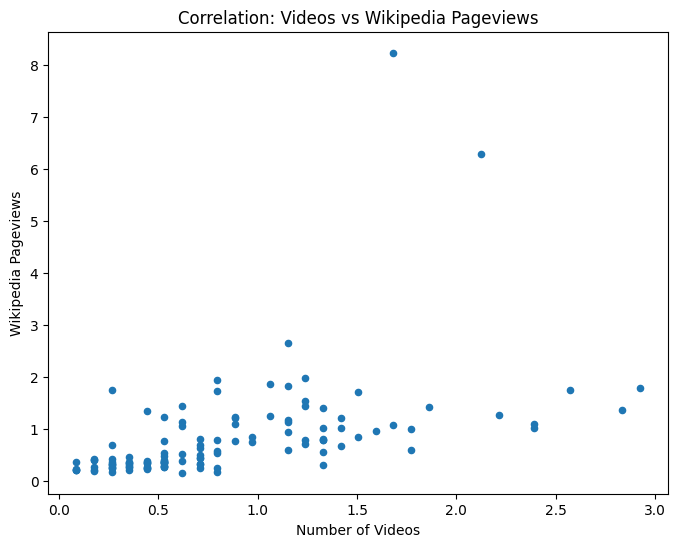

In [7]:
plot2 = df_relative.plot(
    kind='scatter',
    x='Number of Videos',
    y='Wikipedia Pageviews',
    figsize=(8,6),
    title='Correlation: Videos vs Wikipedia Pageviews'
)
plot2

In [8]:

from scipy.stats import pearsonr


# Convert dataframe into series
l1 = df_relative['Wikipedia Pageviews']
l2 = df_relative['Number of Videos']

# Apply the pearsonr()
corr, _ = pearsonr(l1, l2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.493


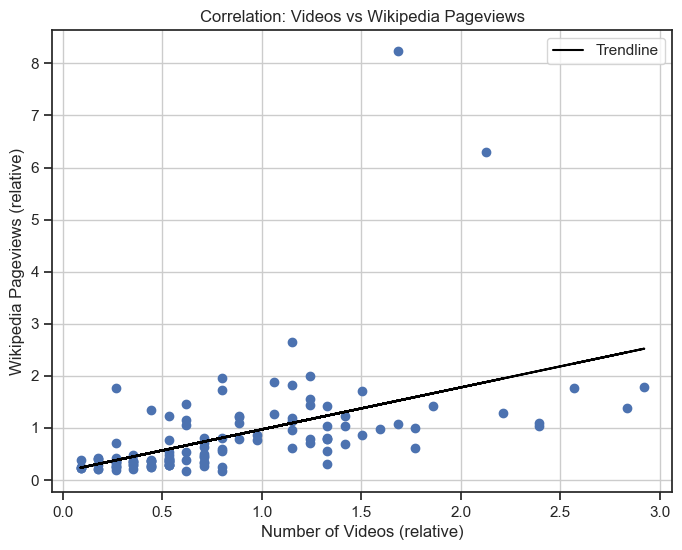

In [128]:
import numpy as np

x = df_relative['Number of Videos']
y = df_relative['Wikipedia Pageviews']

plt.figure(figsize=(8,6))
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)  # lineare Regression
plt.plot(x, m*x + b, color='black', label='Trendline')
plt.xlabel('Number of Videos (relative)')
plt.ylabel('Wikipedia Pageviews (relative)')
plt.title('Correlation: Videos vs Wikipedia Pageviews')
plt.legend()
plt.grid(True)
plt.show()

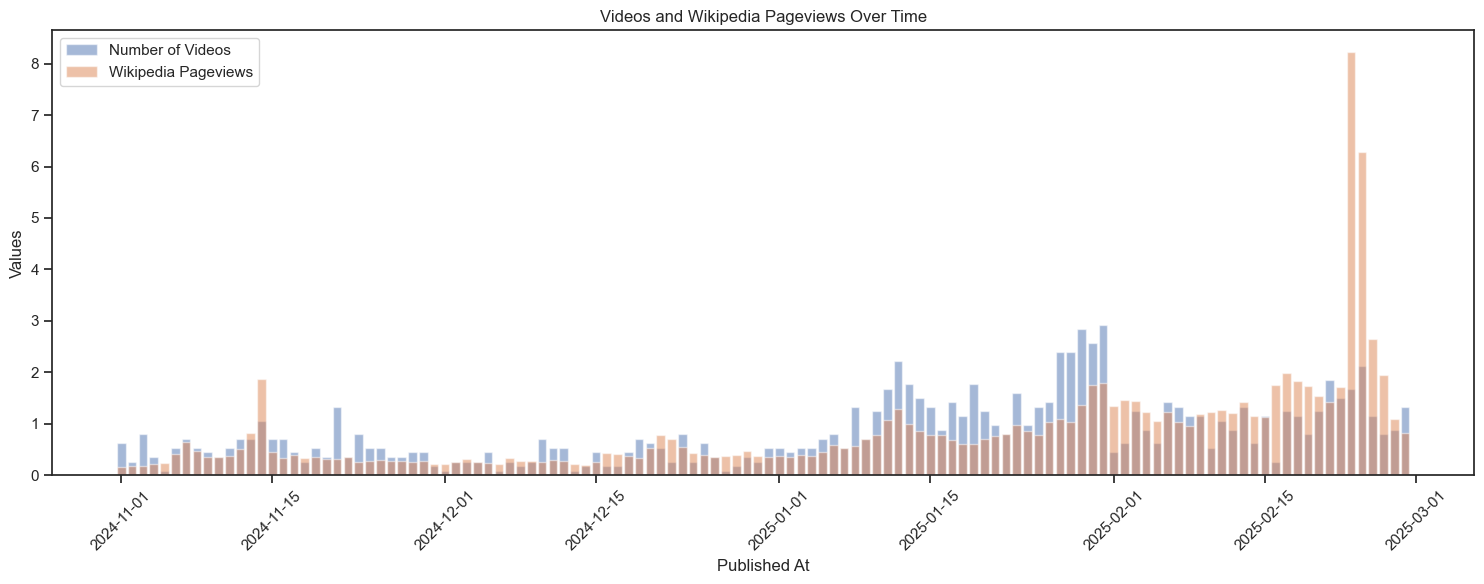

In [152]:
plt.figure(figsize=(15,6))
plt.bar(df_relative['Published At'], df_relative['Number of Videos'], alpha=0.5, label='Number of Videos')
plt.bar(df_relative['Published At'], df_relative['Wikipedia Pageviews'], alpha=0.5, label='Wikipedia Pageviews')

plt.xlabel('Published At')
plt.ylabel('Values')
plt.title('Videos and Wikipedia Pageviews Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("bar_chart.png", dpi=300)
plt.show()


saving data to a json file for the website

In [153]:
import json 

json_str = df_relative.to_json(orient="records", indent=2, force_ascii=False)

with open("AfD_combined_daily_relative.json", "w", encoding="utf-8") as f:
    f.write(json_str)

In [154]:
!pip install seaborn

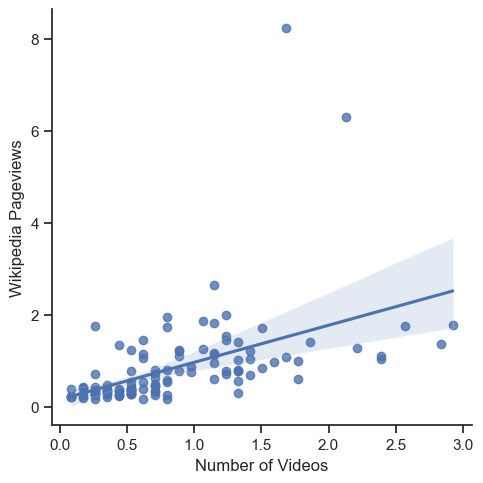

In [13]:
import seaborn as sns

sns.set(style="ticks")

# Show the results of a linear regression
plot3= sns.lmplot(x="Number of Videos", y="Wikipedia Pageviews", data=df_relative)
plot3.savefig('pretty_scatter_plot.png')